In [1]:
import torch
import torch.nn as nn #파이토치에있는 딥러닝레이어만들때 쓰는모듈
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import matplotlib.pyplot as plt


In [2]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # 컨볼루션을 통해 32채널로
        #nn.Conv2d:파이토치의 컨볼루션 레이어를 생성하는 클래스
        #(입력채널,출력채널,커널크기,패딩크기)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # 컨볼루션을 통해 64채널로
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2) #컨볼루션을 통해 128채널로
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        #nn.Linear:파이토치의 완전연결 정의레이어를 생성하는 클래스:3차원을 1차원으로 펼쳐서 출력
        #(입력특성수:{128*3*3:앞선 컨볼루션 레이어에서 생성된 특징,직접계산해야함} 출력특성수)
        self.fc2 = nn.Linear(128, 10)
        #128을 10으로 변환시킨다. 따라서 1*1*10으로 만들어서 최종 분류확률을 가지는 데이터를 만든다.

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #F.relu():맥스풀링을 통과한 결과에 활성화함수 렐루를 적용시켜줌,렐루는 비선형성+음수값을 0으로 만듬
        #self.conv1(x):입력데이터 x에 첫번째 컨볼루션 레이어 적용 된놈
        #F.max_pool2d:첫번째 컨볼루션 레이어 통과한 놈한테 맥스풀링 갈긴다. 2*2윈도우 사용한다.
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 128 * 3 * 3)#평탄화를 하는것을 정의, 128*3*3 직접 계산해야함
        x = F.relu(self.fc1(x))#
        #입력데이터에 첫번째 완전연결레이어를 적용하고 그걸 렐루에 넣어
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
        #F.log_softmax:출력을 로그확률로 변환해서 손실함수에 적용

# FashionMNIST로 실행

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),#텐서로 변환시켜
    transforms.Normalize((0.286,),(0.353,))#정규화를 시
    #정규화를해야함.표준편차랑 평균직접넣어줘

])
train_dataset = datasets.FashionMNIST('./data',train=True,download=True,transform=transform)
test_dataset = datasets.FashionMNIST('./data',train=False,transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
#DataLoader를 사용해서 데이터를 배치 단위로 로드한다. 데이터를 섞는다
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1000,shuffle=False)

In [14]:

image111, label111 = train_dataset[0]

In [16]:
label111

9

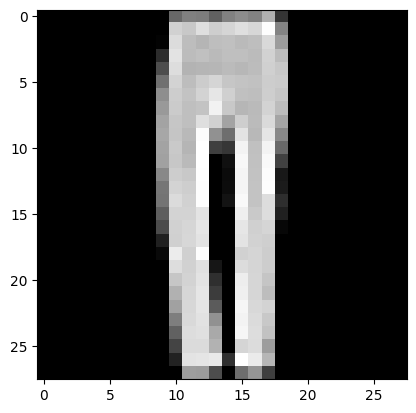

In [21]:
plt.imshow(next(iter(train_loader))[0][0][0],cmap='gray')

In [22]:
model = myCNN()#앞에서 쓴 myCNN을 사용해서 초기화
criterion = nn.CrossEntropyLoss()#손실함수 초기화
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)#sgd이용해서 최적화
#model.parameters():모델의 가중치 및 편향이 여기에 해당한다.

In [11]:
train_losses=[]
test_losses=[]
test_accuracies=[]


In [7]:
def train(model,train_loader,optimizer,epoch):
    model.train()#모델을 트레인모드로 활성화시킨다.
    train_loss=0#훈련손실을 저장하기 위한 변수를 초기화
    for data,target in train_loader:
        optimizer.zero_grad()#옵티마이저의 그래디언트 초기화
        output = model(data)#모델에 입력데이터 전달
        loss = criterion(output,target)#출력과 정답레이블을 사용하여 손실 계산
        train_loss +=loss.item()#현재 손실을 전체 손실에 더해
        loss.backward()#역전파해서 파라미터에대한 그래디언트계산
        optimizer.step()#업데이트

    #평균훈련손실계산
    train_loss/=len(train_loader)#전체훈련 나누기 배치수
    train_losses.append(train_loss)#저장
    print(f'Epoch{epoch},Training loss:{train_loss:.4f}')

In [8]:
def test(model,test_loader):
    model.eval()#모델을 평가모델로 설정
    test_loss=0#초기화
    correct=0#예측수 초기화
    with torch.no_grad():
        for data,target in test_loader:
            output = model(data)#입력데이터 모델에 넣어서 아웃풋으로
            test_loss +=criterion(output,target).item()#출력과 정답레이블 사용해서 손실계산
            pred = output.argmax(dim=1,keepdim=True)#최대 확률은 뭘까
            correct += pred.eq(target.view_as(pred)).sum().item()#예측된 클래스와 정답 레이블 비교하고 누적
    test_loss/=len(test_loader)#평균 테스트 손실
    accuracy=100.* correct/len(test_loader.dataset)#정확도
    test_losses.append(test_loss)#저장
    test_accuracies.append(accuracy)#저장
    print(f'Test loss:{test_loss:.4f},Accuracy:{accuracy:.2f}%')#프린

In [9]:
for epoch in range(1,11):
    train(model,train_loader,optimizer,epoch)
    test(model,test_loader)
    print(f"학습 {epoch} 완료")

Epoch1,Training loss:0.8303
Test loss:0.5507,Accuracy:79.57%
학습 1 완료
Epoch2,Training loss:0.4552
Test loss:0.4455,Accuracy:83.65%
학습 2 완료
Epoch3,Training loss:0.3702
Test loss:0.3702,Accuracy:86.42%
학습 3 완료
Epoch4,Training loss:0.3292
Test loss:0.3419,Accuracy:87.35%
학습 4 완료
Epoch5,Training loss:0.2998
Test loss:0.3296,Accuracy:87.86%
학습 5 완료
Epoch6,Training loss:0.2791
Test loss:0.3264,Accuracy:88.17%
학습 6 완료
Epoch7,Training loss:0.2623
Test loss:0.2925,Accuracy:89.32%
학습 7 완료
Epoch8,Training loss:0.2474
Test loss:0.2859,Accuracy:89.60%
학습 8 완료
Epoch9,Training loss:0.2344
Test loss:0.2846,Accuracy:89.71%
학습 9 완료
Epoch10,Training loss:0.2220
Test loss:0.2655,Accuracy:90.20%
학습 10 완료


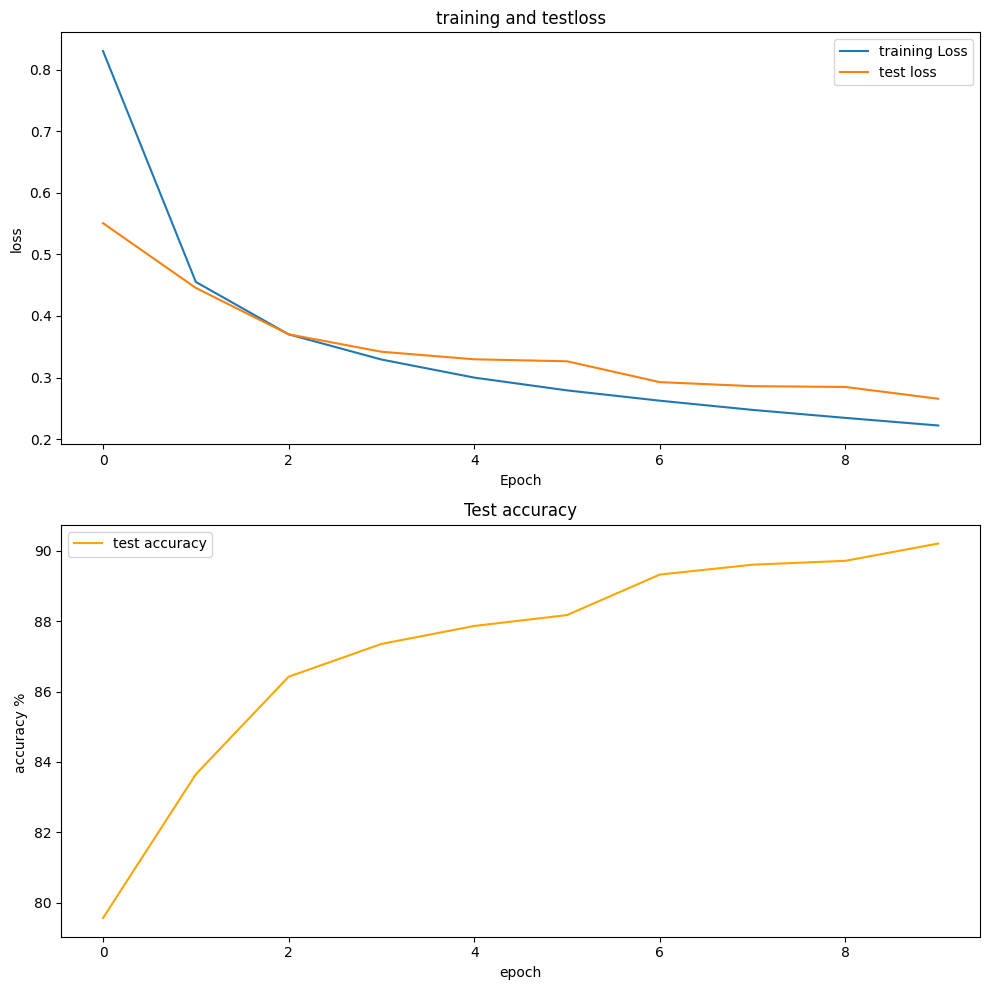

In [10]:
fig,axs = plt.subplots(2,1,figsize=(10,10))
axs[0].plot(train_losses,label="training Loss")
axs[0].plot(test_losses,label="test loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("loss")
axs[0].legend()
axs[0].set_title("training and testloss")

axs[1].plot(test_accuracies,label = "test accuracy",color = "orange")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("accuracy % ")
axs[1].legend()
axs[1].set_title("Test accuracy")

plt.tight_layout()
plt.show()

#학습 2번했을때가 제일 차이가 적네
#정확도는 점점 높아지네

In [12]:
# def calculate_mean_std(loader):
#     mean = 0.
#     std = 0.
#     total_images_count = 0
#     for images, _ in loader:
#         batch_samples = images.size(0)  # 배치 크기
#         images = images.view(batch_samples, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         total_images_count += batch_samples

#     mean /= total_images_count
#     std /= total_images_count

#     return mean, std

In [14]:
calculate_mean_std(train_loader)

(tensor([0.0001]), tensor([0.9078]))

In [15]:
calculate_mean_std(test_loader)

(tensor([0.0024]), tensor([0.9067]))

In [ ]:
#정확한 파라미터를 알고싶으면 사전학습모델을 갖고 놀자